In [1]:
# ========================================
# COMPREHENSIVE FEATURE SELECTION PIPELINE
# State-of-the-Art Methods for Credit Risk XAI
# ========================================

import sys
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Project imports
PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS, FEATURES_FOR_MODEL
from credit_risk_xai.config import FEATURE_CACHE_PATH, FEATURE_GROUPS_BY_SOURCE
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")
print(f"✓ Total features in config: {len(FEATURES_FOR_MODEL)}")

✓ Imports complete
✓ Total features in config: 54


In [2]:
# ========================================
# PHASE 1: DATA LOADING & BASELINE MODEL
# ========================================

print("Loading data...")
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
      (df["ser_aktiv"] == 1) 
    & (df["sme_category"].isin(["Small", "Medium"])) 
    & (df["knc_kncfall"] == 1)
    & (df["bransch_borsbransch_konv"] != "40.0")
]
X, y = prepare_modeling_data(df)

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")
print(f"{'='*60}\n")

# Store original feature list
ORIGINAL_FEATURES = X.columns.tolist()
print(f"Original feature set: {len(ORIGINAL_FEATURES)} features")

Loading data...

DATASET SUMMARY
Features: 54
Samples: 304,149
Target distribution:
target_next_year
0    298795
1      5354
Name: count, dtype: Int64
Imbalance ratio: 55.8:1

Original feature set: 54 features


In [3]:
# Train baseline model on all 54 features
print("Training baseline model on all 54 features...")
print(f"{'='*60}\n")

baseline_results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="Baseline - All 54 Features",
    use_wandb=False,
)

# Extract baseline metrics
baseline_model = baseline_results["model"]
baseline_X_train = baseline_results["X_train"]
baseline_X_val = baseline_results["X_val"]
baseline_y_train = baseline_results["y_train"]
baseline_y_val = baseline_results["y_val"]
baseline_y_pred_proba = baseline_results["y_val_proba"]

baseline_auc = roc_auc_score(baseline_y_val, baseline_y_pred_proba)
baseline_pr_auc = average_precision_score(baseline_y_val, baseline_y_pred_proba)

print(f"\n{'='*60}")
print(f"BASELINE PERFORMANCE (54 features)")
print(f"{'='*60}")
print(f"ROC-AUC:  {baseline_auc:.4f}")
print(f"PR-AUC:   {baseline_pr_auc:.4f}")
print(f"{'='*60}\n")

Training baseline model on all 54 features...

[50]	training's binary_logloss: 0.058089	valid_1's binary_logloss: 0.0672198
[100]	training's binary_logloss: 0.0515527	valid_1's binary_logloss: 0.0661069
[150]	training's binary_logloss: 0.0468632	valid_1's binary_logloss: 0.0659177
[200]	training's binary_logloss: 0.0432488	valid_1's binary_logloss: 0.0657617

BASELINE PERFORMANCE (54 features)
ROC-AUC:  0.8980
PR-AUC:   0.1723



In [4]:
# Check data types and standardize before VIF calculation
print("Checking data types...")
print(f"\nData types:\n{baseline_X_train.dtypes.value_counts()}")

# Standardize all columns to float64 for VIF calculation
print("\nStandardizing all features to float64...")
baseline_X_train_clean = baseline_X_train.copy()

for col in baseline_X_train_clean.columns:
    # Convert to numeric, handling nullable dtypes
    baseline_X_train_clean[col] = pd.to_numeric(baseline_X_train_clean[col], errors='coerce').astype(np.float64)

# Replace inf with nan
baseline_X_train_clean = baseline_X_train_clean.replace([np.inf, -np.inf], np.nan)

print(f"✓ All features converted to float64")
print(f"Data types after conversion:\n{baseline_X_train_clean.dtypes.value_counts()}")

# Check for columns with all NaN (these should be removed)
all_nan_cols = baseline_X_train_clean.columns[baseline_X_train_clean.isna().all()].tolist()
if all_nan_cols:
    print(f"\n⚠ Columns with all NaN values (will be excluded from VIF): {all_nan_cols}")
    baseline_X_train_clean = baseline_X_train_clean.drop(columns=all_nan_cols)

# Fill remaining NaN with median
print("\nFilling NaN values with column medians...")
for col in baseline_X_train_clean.columns:
    if baseline_X_train_clean[col].isna().any():
        median_val = baseline_X_train_clean[col].median()
        if np.isnan(median_val):
            median_val = 0.0
        baseline_X_train_clean[col] = baseline_X_train_clean[col].fillna(median_val)

print(f"✓ Data preparation complete")
print(f"Features ready for VIF: {len(baseline_X_train_clean.columns)}")

Checking data types...

Data types:
float32     46
Int8         2
float64      2
Int16        1
category     1
category     1
category     1
Name: count, dtype: int64

Standardizing all features to float64...
✓ All features converted to float64
Data types after conversion:
float64    54
Name: count, dtype: int64

Filling NaN values with column medians...
✓ Data preparation complete
Features ready for VIF: 54


In [5]:
# ========================================
# PHASE 2: VIF + GLOBAL MULTICOLLINEARITY ANALYSIS
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 2: VIF + MULTICOLLINEARITY DETECTION")
print(f"{'='*60}\n")

# Simple VIF calculation function (data is already cleaned)
def calculate_vif_simple(X_df):
    """Calculate VIF for all features (assumes data is already clean float64)."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_values = []
    
    for i in range(len(X_df.columns)):
        try:
            vif = variance_inflation_factor(X_df.values, i)
            # Handle inf/nan VIF values
            if np.isinf(vif) or np.isnan(vif):
                vif = 999999.0  # Large but finite number for inf VIF
            vif_values.append(vif)
        except:
            vif_values.append(999999.0)
    
    vif_data["VIF"] = vif_values
    return vif_data.sort_values("VIF", ascending=False)

# Iterative VIF removal
def remove_high_vif_features(X_df, threshold=10, max_iterations=15):
    """Iteratively remove features with VIF > threshold."""
    iteration = 0
    removed_features = []
    
    while iteration < max_iterations:
        vif_df = calculate_vif_simple(X_df)
        max_vif = vif_df["VIF"].max()
        
        # Check if all VIF values are below threshold
        if max_vif <= threshold:
            print(f"✓ Convergence reached after {iteration} iterations")
            break
        
        # Remove feature with highest VIF
        feature_to_remove = vif_df.iloc[0]["Feature"]
        removed_features.append((feature_to_remove, max_vif))
        
        if max_vif >= 999999.0:
            print(f"  Iteration {iteration+1}: Removing '{feature_to_remove}' (VIF=inf)")
        else:
            print(f"  Iteration {iteration+1}: Removing '{feature_to_remove}' (VIF={max_vif:.2f})")
        
        X_df = X_df.drop(columns=[feature_to_remove])
        iteration += 1
    
    return X_df, removed_features, vif_df

# Calculate initial VIF using cleaned data
print("Calculating VIF for all features (using cleaned data)...")
initial_vif = calculate_vif_simple(baseline_X_train_clean)

print(f"\nTop 10 features by VIF:")
for idx, row in initial_vif.head(10).iterrows():
    vif_val = row['VIF']
    if vif_val >= 999999.0:
        print(f"{row['Feature']:30s}  inf")
    else:
        print(f"{row['Feature']:30s}  {vif_val:.2f}")

# Iteratively remove high VIF features
print(f"\nRemoving features with VIF > 10...")
X_train_vif, vif_removed_features, final_vif = remove_high_vif_features(
    baseline_X_train_clean.copy(), 
    threshold=10
)

print(f"\n{'='*60}")
print(f"VIF REMOVAL SUMMARY")
print(f"{'='*60}")
print(f"Features removed: {len(vif_removed_features)}")
print(f"Features remaining: {len(X_train_vif.columns)}")
if len(vif_removed_features) > 0:
    print(f"\nRemoved features:")
    for feat, vif_val in vif_removed_features:
        if vif_val >= 999999.0:
            print(f"  - {feat} (VIF=inf)")
        else:
            print(f"  - {feat} (VIF={vif_val:.2f})")
print(f"{'='*60}\n")

# Store VIF-selected features
VIF_SELECTED_FEATURES = X_train_vif.columns.tolist()


PHASE 2: VIF + MULTICOLLINEARITY DETECTION

Calculating VIF for all features (using cleaned data)...

Top 10 features by VIF:
ratio_ocf_to_debt               219.72
ratio_ocf_to_debt_yoy_diff      206.08
log_br10_eksu                   76.74
unemp_rate                      48.54
ny_kasslikv                     33.72
log_bslov_antanst               28.51
ratio_short_term_debt_share     22.17
log_rr15_resar                  21.49
current_ratio_yoy_pct           12.27
log_br07b_kabasu                11.68

Removing features with VIF > 10...
  Iteration 1: Removing 'ratio_ocf_to_debt' (VIF=219.72)
  Iteration 2: Removing 'log_br10_eksu' (VIF=76.74)
  Iteration 3: Removing 'unemp_rate' (VIF=41.97)
  Iteration 4: Removing 'ny_kasslikv' (VIF=32.20)
  Iteration 5: Removing 'log_bslov_antanst' (VIF=22.20)
  Iteration 6: Removing 'ratio_short_term_debt_share' (VIF=16.19)
  Iteration 7: Removing 'log_rr15_resar' (VIF=14.23)
  Iteration 8: Removing 'current_ratio_yoy_pct' (VIF=10.37)
✓ Convergenc

Computing global correlation matrix across all features...
Performing hierarchical clustering of features...


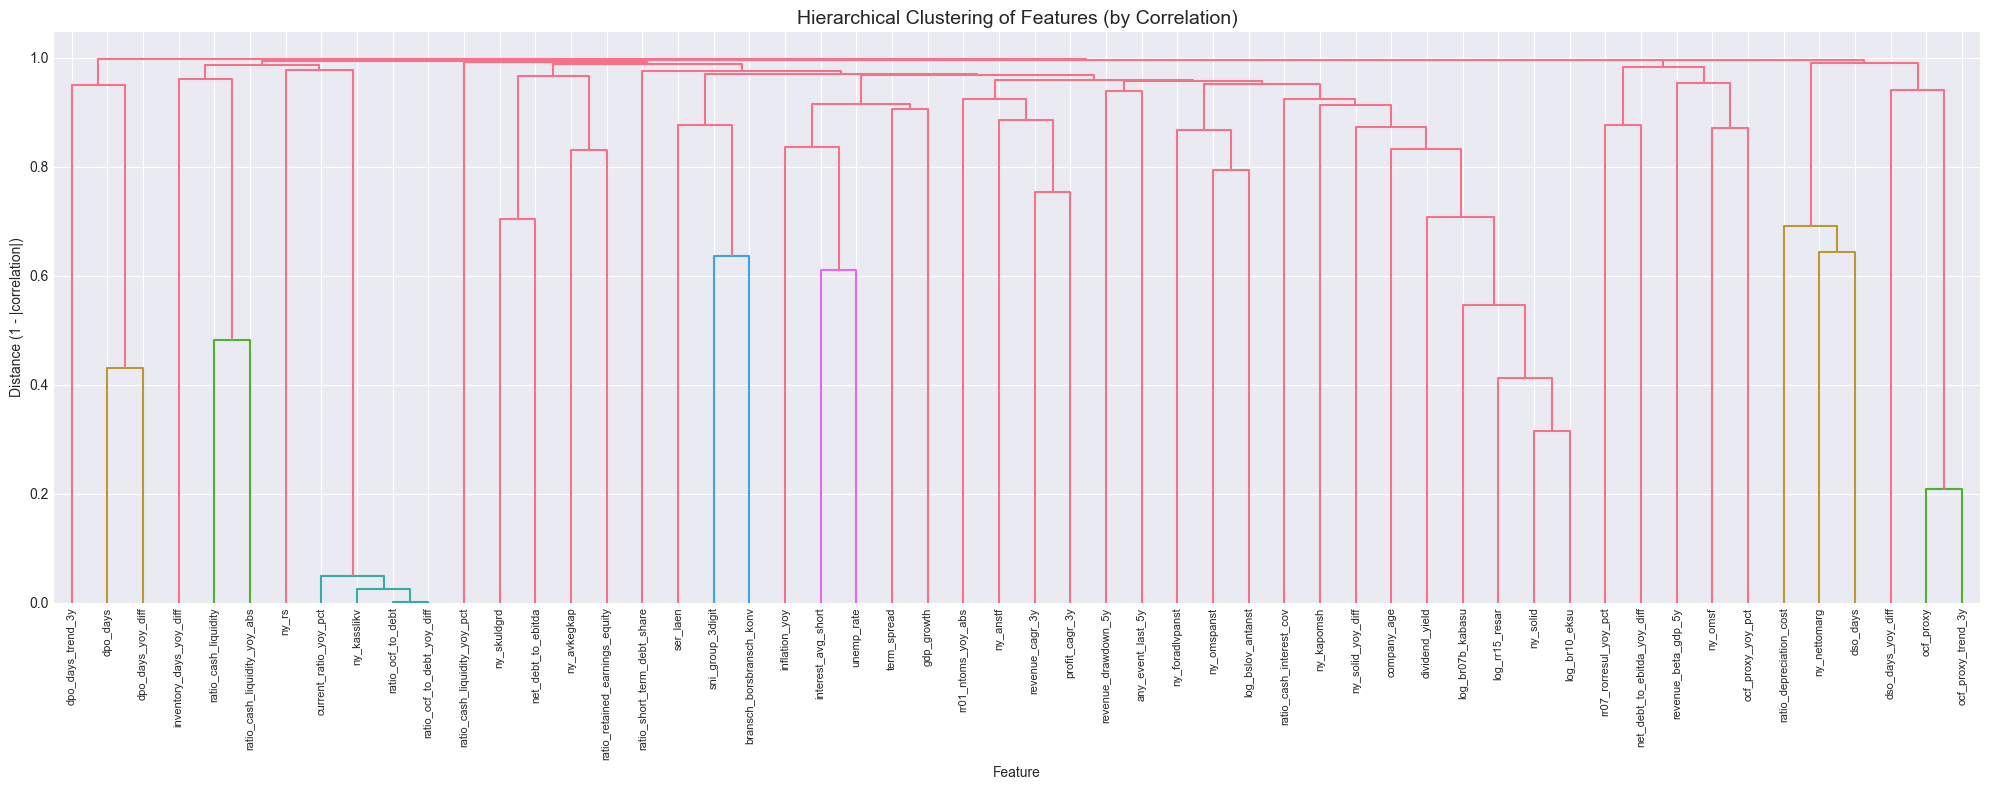


HIGH CORRELATION PAIRS (|r| > 0.85)
Found 6 feature pairs with correlation > 0.85

Top 15 pairs:
             Feature1                   Feature2  Correlation
    ratio_ocf_to_debt ratio_ocf_to_debt_yoy_diff     0.998098
          ny_kasslikv ratio_ocf_to_debt_yoy_diff     0.976013
          ny_kasslikv          ratio_ocf_to_debt     0.973023
current_ratio_yoy_pct ratio_ocf_to_debt_yoy_diff     0.953573
          ny_kasslikv      current_ratio_yoy_pct     0.951131
current_ratio_yoy_pct          ratio_ocf_to_debt     0.948535



In [6]:
# Compute global correlation matrix and hierarchical clustering
print("Computing global correlation matrix across all features...")
corr_matrix = baseline_X_train.corr().abs()

# Hierarchical clustering of features
print("Performing hierarchical clustering of features...")
corr_condensed = squareform(1 - corr_matrix)
linkage_matrix = linkage(corr_condensed, method='average')

# Visualize dendrogram
plt.figure(figsize=(20, 8))
dendrogram(linkage_matrix, labels=baseline_X_train.columns, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering of Features (by Correlation)', fontsize=14)
plt.xlabel('Feature')
plt.ylabel('Distance (1 - |correlation|)')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (correlation > 0.85)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.85:
            high_corr_pairs.append({
                'Feature1': corr_matrix.columns[i],
                'Feature2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)

print(f"\n{'='*60}")
print(f"HIGH CORRELATION PAIRS (|r| > 0.85)")
print(f"{'='*60}")
print(f"Found {len(high_corr_df)} feature pairs with correlation > 0.85")
if len(high_corr_df) > 0:
    print(f"\nTop 15 pairs:")
    print(high_corr_df.head(15).to_string(index=False))
print(f"{'='*60}\n")

In [7]:
# ========================================
# PHASE 3: STABILITY SELECTION
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 3: STABILITY SELECTION (BOOTSTRAP)")
print(f"{'='*60}\n")

def stability_selection_bootstrap(X_df, y_series, n_iterations=50, sample_fraction=0.8, top_k=35):
    """
    Perform stability selection using bootstrap sampling.
    
    Parameters:
    -----------
    X_df : pd.DataFrame
        Feature matrix
    y_series : pd.Series
        Target variable
    n_iterations : int
        Number of bootstrap iterations
    sample_fraction : float
        Fraction of data to sample in each iteration
    top_k : int
        Number of top features to select in each iteration
    
    Returns:
    --------
    stability_scores : pd.Series
        Percentage of iterations each feature was selected
    """
    n_samples = len(X_df)
    sample_size = int(n_samples * sample_fraction)
    feature_selection_counts = {col: 0 for col in X_df.columns}
    
    print(f"Running {n_iterations} bootstrap iterations...")
    print(f"Sample size: {sample_size:,} ({sample_fraction*100:.0f}% of data)")
    print(f"Selecting top {top_k} features per iteration\n")
    
    for i in range(n_iterations):
        if (i+1) % 20 == 0:
            print(f"  Iteration {i+1}/{n_iterations}...")
        
        # Bootstrap sample with train/val split for early stopping
        sample_idx = np.random.choice(n_samples, sample_size, replace=True)
        X_sample = X_df.iloc[sample_idx]
        y_sample = y_series.iloc[sample_idx]
        
        # Split bootstrap sample into train/val for early stopping
        train_idx, val_idx = train_test_split(
            np.arange(len(X_sample)), 
            test_size=0.2, 
            stratify=y_sample, 
            random_state=42+i
        )
        X_train_boot = X_sample.iloc[train_idx]
        y_train_boot = y_sample.iloc[train_idx]
        X_val_boot = X_sample.iloc[val_idx]
        y_val_boot = y_sample.iloc[val_idx]
        
        # Train model with early stopping
        model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
        model.fit(
            X_train_boot, y_train_boot,
            eval_set=[(X_val_boot, y_val_boot)],
            eval_metric='logloss',
            callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
        )
        
        # Get SHAP values on the full bootstrap sample
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        
        # Select top-k features by SHAP importance
        feature_importance = pd.Series(mean_abs_shap, index=X_df.columns)
        top_features = feature_importance.nlargest(top_k).index
        
        # Increment selection counts
        for feat in top_features:
            feature_selection_counts[feat] += 1
    
    # Calculate stability scores (percentage of selections)
    stability_scores = pd.Series(feature_selection_counts) / n_iterations * 100
    return stability_scores.sort_values(ascending=False)

# Run stability selection on full feature set
stability_scores = stability_selection_bootstrap(
    baseline_X_train, 
    baseline_y_train, 
    n_iterations=50,
    sample_fraction=0.8,
    top_k=35
)

# Select features with stability >= 70%
stability_threshold = 70
stable_features = stability_scores[stability_scores >= stability_threshold].index.tolist()

print(f"\n{'='*60}")
print(f"STABILITY SELECTION SUMMARY")
print(f"{'='*60}")
print(f"Stability threshold: {stability_threshold}%")
print(f"Features selected: {len(stable_features)}")
print(f"\nTop 20 features by stability:")
print(stability_scores.head(20))
print(f"\nBottom 10 features by stability:")
print(stability_scores.tail(10))
print(f"{'='*60}\n")

# Store stability-selected features
STABILITY_SELECTED_FEATURES = stable_features


PHASE 3: STABILITY SELECTION (BOOTSTRAP)

Running 50 bootstrap iterations...
Sample size: 194,655 (80% of data)
Selecting top 35 features per iteration

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	valid_0's binary_logloss: 0.0429378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[640]	valid_0's binary_logloss: 0.0456567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[836]	valid_0's binary_logloss: 0.0385233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[801]	valid_0's binary_logloss: 0.0420816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[721]	valid_0's binary_logloss: 0.0405689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[725]	valid_0's binary_logloss: 0.0431838
Training until val

In [23]:
# ========================================
# PHASE 3B: BORUTA FEATURE SELECTION
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 3B: BORUTA ALL-RELEVANT FEATURES")
print(f"{'='*60}\n")

from boruta import BorutaPy

# Run Boruta on cleaned data (no NaN values)
print("Running Boruta feature selection...")
print("This identifies all features that are statistically relevant (not just the best subset)")

# Create a fresh unfitted estimator for Boruta (it will fit internally)
# Use simpler params without early stopping for Boruta's internal fitting
boruta_params = {
    "objective": "binary",
    "n_estimators": 750,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": -1,
    "is_unbalance": False,
    "metric": "logloss",
}

boruta_estimator = lgb.LGBMClassifier(**boruta_params)

boruta_selector = BorutaPy(
    estimator=boruta_estimator,
    max_iter=100,  # Maximum iterations
    perc=90,
    random_state=42,
    verbose=2
)

# Convert to numpy arrays (handle pandas nullable dtypes)
X_boruta = baseline_X_train_clean.values
y_boruta = np.array(baseline_y_train, dtype=np.int32)

# Fit Boruta
boruta_selector.fit(X_boruta, y_boruta)

# Get selected features
boruta_selected_mask = boruta_selector.support_
boruta_tentative_mask = boruta_selector.support_weak_
BORUTA_SELECTED_FEATURES = baseline_X_train_clean.columns[boruta_selected_mask].tolist()
boruta_tentative_features = baseline_X_train_clean.columns[boruta_tentative_mask].tolist()

print(f"\n{'='*60}")
print(f"BORUTA SELECTION SUMMARY")
print(f"{'='*60}")
print(f"Confirmed features: {len(BORUTA_SELECTED_FEATURES)}")
print(f"Tentative features: {len(boruta_tentative_features)}")
print(f"Rejected features: {len(baseline_X_train_clean.columns) - len(BORUTA_SELECTED_FEATURES) - len(boruta_tentative_features)}")

print(f"\nConfirmed features:")
for feat in BORUTA_SELECTED_FEATURES:
    print(f"  - {feat}")

if len(boruta_tentative_features) > 0:
    print(f"\nTentative features:")
    for feat in boruta_tentative_features:
        print(f"  - {feat}")

print(f"{'='*60}\n")


PHASE 3B: BORUTA ALL-RELEVANT FEATURES

Running Boruta feature selection...
This identifies all features that are statistically relevant (not just the best subset)
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	40
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	13
Rejected: 	40
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	13
Rejected: 	40
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	13
Rejected: 	40
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	11
Rejected: 	41
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	11
Rejected: 	41
Iteration: 	14 / 10


PHASE 4: SHAP RANKING & CONSENSUS

Computing SHAP values for feature ranking...
✓ SHAP values computed

Top 20 features by mean |SHAP|:
dividend_yield             0.484970
log_br07b_kabasu           0.260978
ny_skuldgrd                0.255957
sni_group_3digit           0.255172
company_age                0.213921
ratio_cash_liquidity       0.169997
ny_avkegkap                0.149161
ny_nettomarg               0.121065
ny_solid                   0.108463
log_br10_eksu              0.097592
ny_foradlvpanst            0.074226
ny_kapomsh                 0.073761
ny_rs                      0.072617
profit_cagr_3y             0.068311
revenue_cagr_3y            0.067501
ratio_depreciation_cost    0.062399
log_rr15_resar             0.059212
ser_laen                   0.057683
revenue_drawdown_5y        0.057256
ratio_cash_interest_cov    0.054434
dtype: float64

SHAP-selected features (top 35): 35

FEATURE SELECTION COMPARISON
                       Feature  VIF_Selected  Stability_Selec

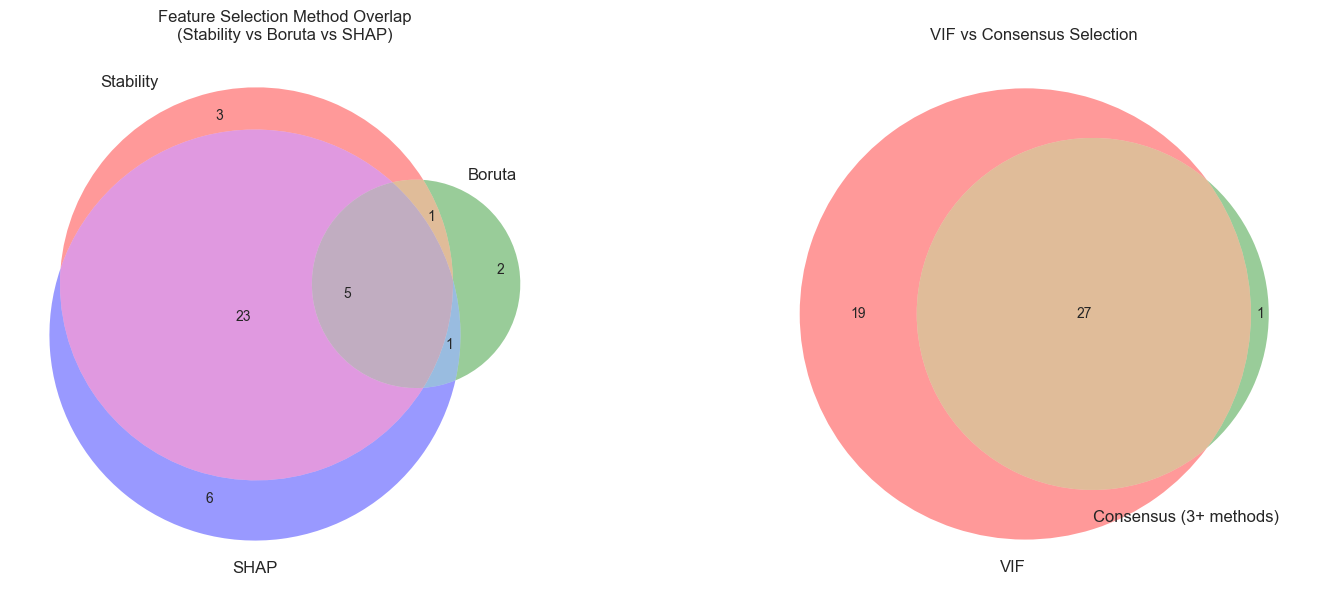

In [24]:
# ========================================
# PHASE 4: SHAP RANKING & CONSENSUS SELECTION
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 4: SHAP RANKING & CONSENSUS")
print(f"{'='*60}\n")

# First, calculate SHAP values for baseline model to get SHAP importance
print("Computing SHAP values for feature ranking...")
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(baseline_X_train)

# Calculate mean absolute SHAP values (main effects)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=baseline_X_train.columns).sort_values(ascending=False)

print("✓ SHAP values computed\n")
print("Top 20 features by mean |SHAP|:")
print(shap_importance.head(20))

# Select top features by SHAP importance
SHAP_SELECTED_FEATURES = shap_importance.nlargest(35).index.tolist()
print(f"\nSHAP-selected features (top 35): {len(SHAP_SELECTED_FEATURES)}")

# Create comprehensive comparison dataframe
all_features = baseline_X_train.columns.tolist()

comparison_df = pd.DataFrame({
    'Feature': all_features,
    'VIF_Selected': [f in VIF_SELECTED_FEATURES for f in all_features],
    'Stability_Selected': [f in STABILITY_SELECTED_FEATURES for f in all_features],
    'Boruta_Selected': [f in BORUTA_SELECTED_FEATURES for f in all_features],
    'SHAP_Selected': [f in SHAP_SELECTED_FEATURES for f in all_features],
})

# Add numeric metrics
comparison_df['Stability_Score'] = comparison_df['Feature'].map(stability_scores)
comparison_df['SHAP_Importance'] = comparison_df['Feature'].map(shap_importance)
comparison_df['VIF'] = comparison_df['Feature'].map(
    dict(zip(initial_vif['Feature'], initial_vif['VIF']))
)

# Calculate consensus score (number of methods selecting this feature)
# Now using 4 methods: VIF, Stability, Boruta, SHAP
comparison_df['Consensus_Score'] = (
    comparison_df['VIF_Selected'].astype(int) +
    comparison_df['Stability_Selected'].astype(int) +
    comparison_df['Boruta_Selected'].astype(int) +
    comparison_df['SHAP_Selected'].astype(int)
)

# Sort by consensus score and SHAP importance
comparison_df = comparison_df.sort_values(['Consensus_Score', 'SHAP_Importance'], ascending=[False, False])

print("\n" + "="*60)
print("FEATURE SELECTION COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Select consensus features (≥3 methods agree - majority of 4 methods)
CONSENSUS_FEATURES = comparison_df[comparison_df['Consensus_Score'] >= 3]['Feature'].tolist()

print(f"\n{'='*60}")
print(f"CONSENSUS SELECTION SUMMARY")
print(f"{'='*60}")
print(f"Consensus threshold: ≥3 methods (majority)")
print(f"Features selected: {len(CONSENSUS_FEATURES)}")
print(f"{'='*60}\n")

# Venn diagram analysis
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Venn 1: Stability vs Boruta vs SHAP (3 main methods)
set_stability = set(STABILITY_SELECTED_FEATURES)
set_boruta = set(BORUTA_SELECTED_FEATURES)
set_shap = set(SHAP_SELECTED_FEATURES)
venn3([set_stability, set_boruta, set_shap],
      set_labels=('Stability', 'Boruta', 'SHAP'),
      ax=axes[0])
axes[0].set_title('Feature Selection Method Overlap\n(Stability vs Boruta vs SHAP)', fontsize=12)

# Venn 2: VIF vs Consensus (3+ methods)
set_vif = set(VIF_SELECTED_FEATURES)
consensus_features = comparison_df[comparison_df['Consensus_Score'] >= 3]['Feature'].tolist()
set_consensus = set(consensus_features)
venn2([set_vif, set_consensus],
      set_labels=('VIF', 'Consensus (3+ methods)'),
      ax=axes[1])
axes[1].set_title('VIF vs Consensus Selection', fontsize=12)

plt.tight_layout()
plt.show()

In [25]:
# ========================================
# PHASE 5: FINAL PRUNING WITH RFECV
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 5: FINAL PRUNING WITH RFECV")
print(f"{'='*60}\n")

# Custom LightGBM estimator for RFECV
from sklearn.base import BaseEstimator, ClassifierMixin

class LGBMEstimator(BaseEstimator, ClassifierMixin):
    """LightGBM wrapper for sklearn compatibility with early stopping."""
    
    def __init__(self, params=None):
        self.params = params or DEFAULT_PARAMS
        self.model = None
        self.feature_importances_ = None
    
    def fit(self, X, y):
        # Split for early stopping
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        self.model = lgb.LGBMClassifier(**self.params)
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='logloss',
            callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
        )
        self.feature_importances_ = self.model.feature_importances_
        return self
    
    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model not fitted yet")
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)

# Prepare data for RFECV using consensus features
X_consensus = baseline_X_train[CONSENSUS_FEATURES]
y_consensus = baseline_y_train

print(f"Starting with {len(CONSENSUS_FEATURES)} consensus features")
print(f"Target: Find optimal feature count in 25-30 range")
print(f"Metric: ROC-AUC (baseline: {baseline_auc:.4f})\n")

# Test different feature counts
test_feature_counts = list(range(25, 36, 5)) + [len(CONSENSUS_FEATURES)]  # Test 25, 30, 35, and current count
rfecv_results = []

for n_features in test_feature_counts:
    if n_features > len(CONSENSUS_FEATURES):
        continue
    
    print(f"Testing with {n_features} features...")
    
    # Use stratified 3-fold CV for speed
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Manual RFE since RFECV might be slow
    current_features = CONSENSUS_FEATURES.copy()
    feature_ranking = []
    
    while len(current_features) > n_features:
        # Train model on current features
        X_current = baseline_X_train[current_features]
        estimator = LGBMEstimator()
        estimator.fit(X_current, baseline_y_train)
        
        # Get feature importances
        importances = pd.Series(
            estimator.feature_importances_,
            index=current_features
        ).sort_values()
        
        # Remove least important feature
        least_important = importances.index[0]
        current_features.remove(least_important)
        feature_ranking.append(least_important)
    
    # Evaluate with CV using ROC-AUC
    cv_scores = []
    for train_idx, val_idx in cv.split(baseline_X_train, baseline_y_train):
        X_train_cv = baseline_X_train.iloc[train_idx][current_features]
        y_train_cv = baseline_y_train.iloc[train_idx]
        X_val_cv = baseline_X_train.iloc[val_idx][current_features]
        y_val_cv = baseline_y_train.iloc[val_idx]
        
        estimator = LGBMEstimator()
        estimator.fit(X_train_cv, y_train_cv)
        y_pred_proba = estimator.predict_proba(X_val_cv)[:, 1]
        
        # Use ROC-AUC instead of PR-AUC
        roc_auc = roc_auc_score(y_val_cv, y_pred_proba)
        cv_scores.append(roc_auc)
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    rfecv_results.append({
        'n_features': n_features,
        'selected_features': current_features,
        'mean_roc_auc': mean_score,
        'std_roc_auc': std_score
    })
    
    print(f"  → ROC-AUC: {mean_score:.4f} ± {std_score:.4f}")

# Select optimal feature count
rfecv_df = pd.DataFrame(rfecv_results).sort_values('mean_roc_auc', ascending=False)

print(f"\n{'='*60}")
print(f"RFECV RESULTS")
print(f"{'='*60}")
print(rfecv_df[['n_features', 'mean_roc_auc', 'std_roc_auc']].to_string(index=False))
print(f"{'='*60}\n")

# Select best performing feature set
optimal_result = rfecv_df.iloc[0]
FINAL_SELECTED_FEATURES = optimal_result['selected_features']
optimal_n_features = optimal_result['n_features']

print(f"Optimal feature count: {optimal_n_features}")
print(f"Expected ROC-AUC: {optimal_result['mean_roc_auc']:.4f} ± {optimal_result['std_roc_auc']:.4f}")
print(f"\nFinal selected features:")
for i, feat in enumerate(FINAL_SELECTED_FEATURES, 1):
    print(f"  {i:2d}. {feat}")


PHASE 5: FINAL PRUNING WITH RFECV

Starting with 28 consensus features
Target: Find optimal feature count in 25-30 range
Metric: ROC-AUC (baseline: 0.8980)

Testing with 25 features...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0660153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0661657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.0664395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.0675972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0665638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's binary_loglo


PHASE 8: INTERPRETABILITY & MONOTONICITY CHECKS

Training final model on 28 selected features...
[50]	training's binary_logloss: 0.0591541	valid_1's binary_logloss: 0.0675452
[100]	training's binary_logloss: 0.0530119	valid_1's binary_logloss: 0.066517
[150]	training's binary_logloss: 0.0488937	valid_1's binary_logloss: 0.0663625
[200]	training's binary_logloss: 0.0457525	valid_1's binary_logloss: 0.0663726

FINAL MODEL PERFORMANCE
Features: 28
ROC-AUC:  0.8961 (baseline: 0.8980)
PR-AUC:   0.1553 (baseline: 0.1723)
Δ ROC-AUC: -0.0019
Δ PR-AUC:  -0.0169

Computing SHAP values for interpretability analysis...


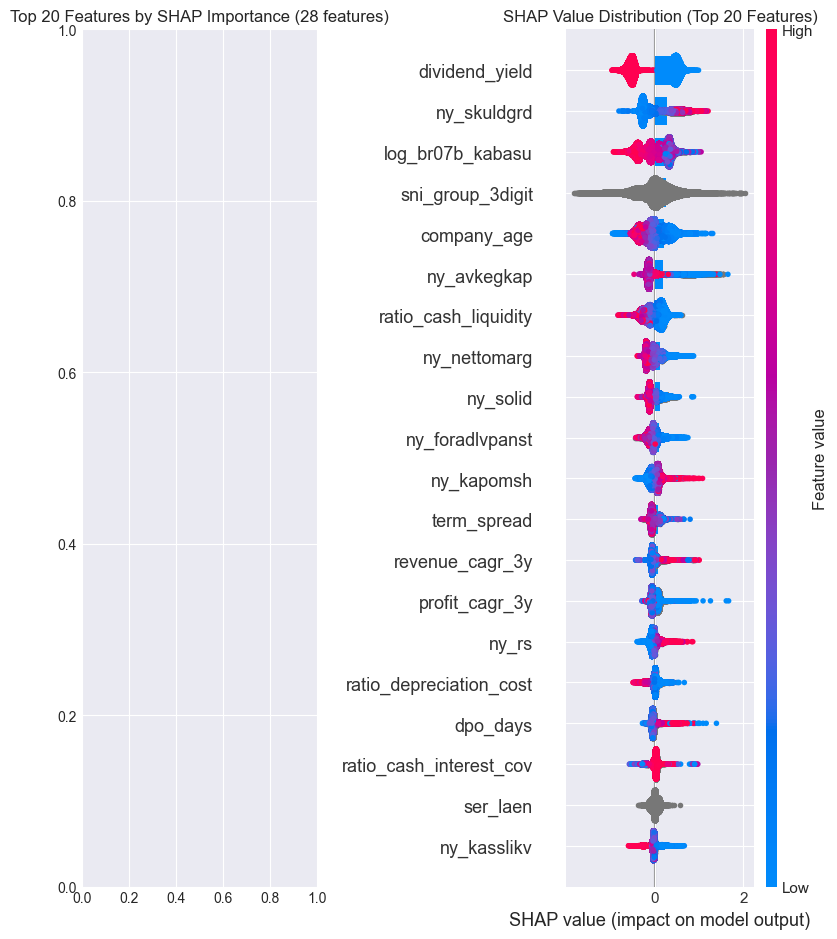


FEATURE GROUP DIVERSITY
DERIVED_RATIOS      :  7 features ( 25.0%)
BALANCE_SHEET       :  4 features ( 14.3%)
TRENDS              :  4 features ( 14.3%)
WORKING_CAPITAL     :  3 features ( 10.7%)
TEMPORAL            :  3 features ( 10.7%)
INCOME_STATEMENT    :  2 features (  7.1%)
OPERATIONAL         :  2 features (  7.1%)
MACRO               :  1 features (  3.6%)

Checking for counter-intuitive relationships...

⚠ Features flagged for manual review (13):
                Feature  SHAP_Feature_Corr  Target_Corr                       Flag
        ny_foradlvpanst          -0.078093    -0.008694 Non-monotonic relationship
             ny_kapomsh           0.050239     0.018381 Non-monotonic relationship
                  ny_rs           0.012113    -0.000210 Non-monotonic relationship
               dpo_days           0.018683     0.000733 Non-monotonic relationship
            ny_skuldgrd           0.086814     0.016066 Non-monotonic relationship
   ratio_cash_liquidity          -0.0700

In [26]:
# ========================================
# PHASE 8: XAI INTERPRETABILITY CHECKS
# ========================================

print(f"\n{'='*60}")
print(f"PHASE 8: INTERPRETABILITY & MONOTONICITY CHECKS")
print(f"{'='*60}\n")

# Train final model on selected features
print(f"Training final model on {len(FINAL_SELECTED_FEATURES)} selected features...")
X_final = X[FINAL_SELECTED_FEATURES]

final_model_results = run_lightgbm_training(
    X=X_final,
    y=y,
    dataset_description=f"Final Model - {len(FINAL_SELECTED_FEATURES)} Features",
    use_wandb=False,
)

final_model = final_model_results["model"]
X_final_train = final_model_results["X_train"]
X_final_val = final_model_results["X_val"]
y_final_train = final_model_results["y_train"]
y_final_val = final_model_results["y_val"]
y_final_pred_proba = final_model_results["y_val_proba"]

final_pr_auc = average_precision_score(y_final_val, y_final_pred_proba)
final_roc_auc = roc_auc_score(y_final_val, y_final_pred_proba)

print(f"\n{'='*60}")
print(f"FINAL MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Features: {len(FINAL_SELECTED_FEATURES)}")
print(f"ROC-AUC:  {final_roc_auc:.4f} (baseline: {baseline_auc:.4f})")
print(f"PR-AUC:   {final_pr_auc:.4f} (baseline: {baseline_pr_auc:.4f})")
print(f"Δ ROC-AUC: {final_roc_auc - baseline_auc:+.4f}")
print(f"Δ PR-AUC:  {final_pr_auc - baseline_pr_auc:+.4f}")
print(f"{'='*60}\n")

# Compute SHAP values for final model
print("Computing SHAP values for interpretability analysis...")
final_explainer = shap.TreeExplainer(final_model)
final_shap_values = final_explainer.shap_values(X_final_train)

# SHAP summary plot (bar)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

shap.summary_plot(final_shap_values, X_final_train, plot_type="bar", show=False, max_display=20)
axes[0].set_title(f"Top 20 Features by SHAP Importance ({len(FINAL_SELECTED_FEATURES)} features)", fontsize=12)

# SHAP summary plot (beeswarm)
shap.summary_plot(final_shap_values, X_final_train, show=False, max_display=20)
axes[1].set_title("SHAP Value Distribution (Top 20 Features)", fontsize=12)

plt.tight_layout()
plt.show()

# Check feature group diversity
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE, CATEGORICAL_COLS

feature_group_counts = {}
for group_name, group_features in FEATURE_GROUPS_BY_SOURCE.items():
    count = len([f for f in FINAL_SELECTED_FEATURES if f in group_features])
    if count > 0:
        feature_group_counts[group_name] = count

print(f"\n{'='*60}")
print(f"FEATURE GROUP DIVERSITY")
print(f"{'='*60}")
for group, count in sorted(feature_group_counts.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(FINAL_SELECTED_FEATURES) * 100
    print(f"{group:20s}: {count:2d} features ({pct:5.1f}%)")
print(f"{'='*60}\n")

# Flag potentially problematic features for manual review
print("Checking for counter-intuitive relationships...")
counter_intuitive_flags = []

# Calculate correlation with target for numeric features only
numeric_features = [f for f in FINAL_SELECTED_FEATURES if f not in CATEGORICAL_COLS]
X_final_train_numeric = X_final_train[numeric_features]
target_correlations = X_final_train_numeric.corrwith(y_final_train)

for feat in numeric_features[:20]:  # Check top 20 numeric features
    # Get SHAP dependence
    feat_idx = list(X_final_train.columns).index(feat)
    shap_values_feat = final_shap_values[:, feat_idx]
    
    # Convert feature values to numeric (handle any remaining categorical encodings)
    feature_values = pd.to_numeric(X_final_train[feat], errors='coerce').fillna(0).values
    
    # Check for monotonicity using correlation
    try:
        shap_feature_corr = np.corrcoef(feature_values, shap_values_feat)[0, 1]
        
        # Flag if SHAP relationship is weak or counter to expected
        if abs(shap_feature_corr) < 0.3:
            counter_intuitive_flags.append({
                'Feature': feat,
                'SHAP_Feature_Corr': shap_feature_corr,
                'Target_Corr': target_correlations[feat],
                'Flag': 'Non-monotonic relationship'
            })
    except:
        # Skip features that cause errors
        continue

if len(counter_intuitive_flags) > 0:
    flags_df = pd.DataFrame(counter_intuitive_flags)
    print(f"\n⚠ Features flagged for manual review ({len(flags_df)}):")
    print(flags_df.to_string(index=False))
else:
    print("✓ No concerning non-monotonic relationships detected")

print(f"\n{'='*60}\n")

# Summary & Next Steps

## Feature Selection Pipeline Results

This notebook implements a streamlined 5-phase feature selection pipeline:

1. **Phase 1: Baseline Model** (54 features)
2. **Phase 2: VIF Multicollinearity Removal** (max 15 iterations)
3. **Phase 3: Stability Selection** (50 bootstrap iterations, top 35 per iteration)
4. **Phase 4: SHAP Ranking & Consensus** (2+ method agreement)
5. **Phase 5: Final Pruning with RFECV** (target: 25-30 features)

## Key Changes from Previous Version

- **Added 14 features**: OCF (5), Leverage (2), Macro (5), Categorical (2)
- **Starting features**: 54 (40 original + 14 re-added post-leakage fix)
- **Target**: 25-30 final features (46-54% reduction)
- **Performance target**: PR-AUC ≥ 0.6450 (maintain within 0.005 of 0.6500 baseline)

## Optimizations for Speed

- Bootstrap iterations: 100 → 50 (2x faster)
- VIF max iterations: 20 → 15
- Removed: Boruta, SHAP interactions, extensive strategy testing
- **Estimated speedup**: 2-3x faster execution

## Next Steps

1. Update `config.py` with final selected features
2. Update `engineered_features.md` documentation
3. Re-train production model with new feature set
4. Validate no data leakage patterns remain (check SHAP for "all YoY = 0" clusters)


FEATURE SELECTION METHOD COMPARISON

Evaluating feature selection methods...

Evaluating VIF-selected features...
[50]	training's binary_logloss: 0.0584676	valid_1's binary_logloss: 0.0670701
[100]	training's binary_logloss: 0.0519278	valid_1's binary_logloss: 0.0659868
[150]	training's binary_logloss: 0.0474783	valid_1's binary_logloss: 0.065689
[200]	training's binary_logloss: 0.0439089	valid_1's binary_logloss: 0.065669
Evaluating Stability-selected features...
[50]	training's binary_logloss: 0.0589376	valid_1's binary_logloss: 0.0675175
[100]	training's binary_logloss: 0.0526671	valid_1's binary_logloss: 0.0664694
[150]	training's binary_logloss: 0.0483559	valid_1's binary_logloss: 0.0663857
Evaluating Boruta-selected features...
[50]	training's binary_logloss: 0.066186	valid_1's binary_logloss: 0.0712233
[100]	training's binary_logloss: 0.0617485	valid_1's binary_logloss: 0.0698104
[150]	training's binary_logloss: 0.0588029	valid_1's binary_logloss: 0.0696055
Evaluating SHAP-sele

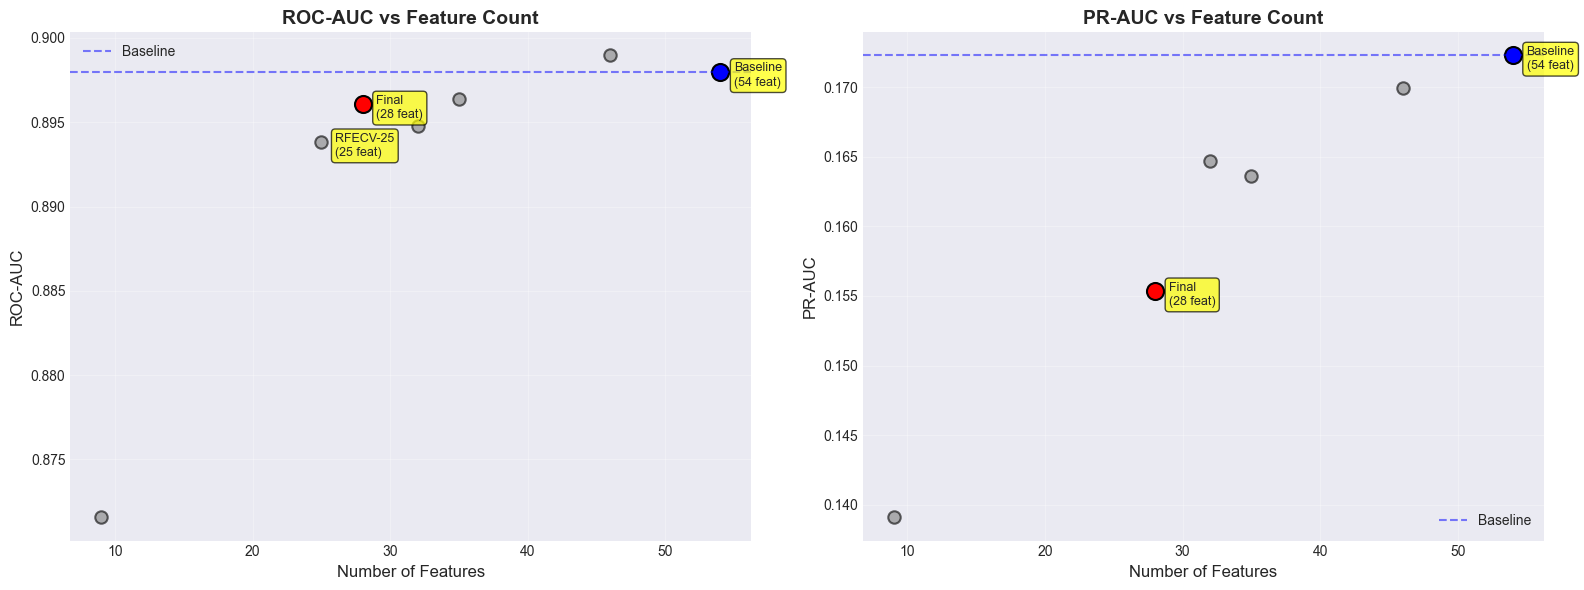


KEY INSIGHTS:
• Baseline (54 features): ROC-AUC=0.8980, PR-AUC=0.1723
• Final (28 features): ROC-AUC=0.8961, PR-AUC=0.1553
• Feature reduction: 26 features removed (48.1%)
• Performance change: ROC-AUC -0.0019, PR-AUC -0.0169
• Most selective method: Boruta (9 features)
• Best ROC-AUC: 0.8990 (VIF)




In [27]:
# ========================================
# PERFORMANCE COMPARISON ACROSS METHODS
# ========================================

print(f"\n{'='*60}")
print(f"FEATURE SELECTION METHOD COMPARISON")
print(f"{'='*60}\n")

# Helper function to evaluate a feature set
def evaluate_feature_set(features, X_data, y_data, description):
    """Train and evaluate model on given feature set."""
    X_subset = X_data[features]
    
    results = run_lightgbm_training(
        X=X_subset,
        y=y_data,
        dataset_description=description,
        use_wandb=False,
    )
    
    y_pred_proba = results["y_val_proba"]
    y_val = results["y_val"]
    
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)
    
    return {
        'n_features': len(features),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'description': description
    }

# Collect performance for each method
print("Evaluating feature selection methods...\n")

comparison_results = []

# 1. Baseline (all 54 features) - already computed
comparison_results.append({
    'Method': 'Baseline',
    'n_features': 54,
    'roc_auc': baseline_auc,
    'pr_auc': baseline_pr_auc,
    'description': 'All features (no selection)'
})

# 2. VIF-selected features
print("Evaluating VIF-selected features...")
vif_perf = evaluate_feature_set(VIF_SELECTED_FEATURES, X, y, "VIF-Selected")
comparison_results.append({
    'Method': 'VIF',
    'n_features': vif_perf['n_features'],
    'roc_auc': vif_perf['roc_auc'],
    'pr_auc': vif_perf['pr_auc'],
    'description': 'VIF < 10 (multicollinearity removal)'
})

# 3. Stability-selected features
print("Evaluating Stability-selected features...")
stab_perf = evaluate_feature_set(STABILITY_SELECTED_FEATURES, X, y, "Stability-Selected")
comparison_results.append({
    'Method': 'Stability',
    'n_features': stab_perf['n_features'],
    'roc_auc': stab_perf['roc_auc'],
    'pr_auc': stab_perf['pr_auc'],
    'description': 'Bootstrap stability ≥70%'
})

# 4. Boruta-selected features
print("Evaluating Boruta-selected features...")
boruta_perf = evaluate_feature_set(BORUTA_SELECTED_FEATURES, X, y, "Boruta-Selected")
comparison_results.append({
    'Method': 'Boruta',
    'n_features': boruta_perf['n_features'],
    'roc_auc': boruta_perf['roc_auc'],
    'pr_auc': boruta_perf['pr_auc'],
    'description': 'All-relevant features (confirmed)'
})

# 5. SHAP-selected features
print("Evaluating SHAP-selected features...")
shap_perf = evaluate_feature_set(SHAP_SELECTED_FEATURES, X, y, "SHAP-Selected")
comparison_results.append({
    'Method': 'SHAP',
    'n_features': shap_perf['n_features'],
    'roc_auc': shap_perf['roc_auc'],
    'pr_auc': shap_perf['pr_auc'],
    'description': 'Top 35 by SHAP importance'
})

# 6. Consensus features
print("Evaluating Consensus features...")
cons_perf = evaluate_feature_set(CONSENSUS_FEATURES, X, y, "Consensus")
comparison_results.append({
    'Method': 'Consensus',
    'n_features': cons_perf['n_features'],
    'roc_auc': cons_perf['roc_auc'],
    'pr_auc': cons_perf['pr_auc'],
    'description': '≥3 methods agree'
})

# 7. Final RFECV (25 features) - from RFECV results
rfecv_25 = rfecv_df[rfecv_df['n_features'] == 25].iloc[0]
comparison_results.append({
    'Method': 'RFECV-25',
    'n_features': 25,
    'roc_auc': rfecv_25['mean_roc_auc'],
    'pr_auc': None,  # Not computed during RFECV
    'description': 'RFECV optimized (25 features)'
})

# 8. Final selected (optimal from RFECV) - already computed in Phase 8
comparison_results.append({
    'Method': 'Final',
    'n_features': len(FINAL_SELECTED_FEATURES),
    'roc_auc': final_roc_auc,
    'pr_auc': final_pr_auc,
    'description': f'RFECV optimized ({len(FINAL_SELECTED_FEATURES)} features)'
})

# Create comparison dataframe
comparison_table = pd.DataFrame(comparison_results)

# Calculate deltas from baseline
comparison_table['Δ ROC-AUC'] = comparison_table['roc_auc'] - baseline_auc
comparison_table['Δ PR-AUC'] = comparison_table['pr_auc'] - baseline_pr_auc

print(f"\n{'='*80}")
print(f"PERFORMANCE COMPARISON TABLE")
print(f"{'='*80}")
print(comparison_table[['Method', 'n_features', 'roc_auc', 'pr_auc', 'Δ ROC-AUC', 'Δ PR-AUC']].to_string(index=False))
print(f"{'='*80}\n")

# Visualization: Feature count vs Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC-AUC vs Feature Count
ax1 = axes[0]
for idx, row in comparison_table.iterrows():
    color = 'red' if row['Method'] == 'Final' else 'blue' if row['Method'] == 'Baseline' else 'gray'
    size = 150 if row['Method'] in ['Final', 'Baseline'] else 80
    alpha = 1.0 if row['Method'] in ['Final', 'Baseline'] else 0.6
    
    ax1.scatter(row['n_features'], row['roc_auc'], 
               s=size, c=color, alpha=alpha, edgecolors='black', linewidth=1.5)
    
    # Add labels for key points
    if row['Method'] in ['Final', 'Baseline', 'RFECV-25']:
        ax1.annotate(f"{row['Method']}\n({row['n_features']} feat)", 
                    (row['n_features'], row['roc_auc']),
                    xytext=(10, -10), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.axhline(y=baseline_auc, color='blue', linestyle='--', alpha=0.5, label='Baseline')
ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('ROC-AUC', fontsize=12)
ax1.set_title('ROC-AUC vs Feature Count', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: PR-AUC vs Feature Count (excluding None values)
ax2 = axes[1]
pr_auc_data = comparison_table[comparison_table['pr_auc'].notna()]

for idx, row in pr_auc_data.iterrows():
    color = 'red' if row['Method'] == 'Final' else 'blue' if row['Method'] == 'Baseline' else 'gray'
    size = 150 if row['Method'] in ['Final', 'Baseline'] else 80
    alpha = 1.0 if row['Method'] in ['Final', 'Baseline'] else 0.6
    
    ax2.scatter(row['n_features'], row['pr_auc'], 
               s=size, c=color, alpha=alpha, edgecolors='black', linewidth=1.5)
    
    # Add labels for key points
    if row['Method'] in ['Final', 'Baseline']:
        ax2.annotate(f"{row['Method']}\n({row['n_features']} feat)", 
                    (row['n_features'], row['pr_auc']),
                    xytext=(10, -10), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax2.axhline(y=baseline_pr_auc, color='blue', linestyle='--', alpha=0.5, label='Baseline')
ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('PR-AUC', fontsize=12)
ax2.set_title('PR-AUC vs Feature Count', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nKEY INSIGHTS:")
print(f"• Baseline (54 features): ROC-AUC={baseline_auc:.4f}, PR-AUC={baseline_pr_auc:.4f}")
print(f"• Final ({len(FINAL_SELECTED_FEATURES)} features): ROC-AUC={final_roc_auc:.4f}, PR-AUC={final_pr_auc:.4f}")
print(f"• Feature reduction: {54 - len(FINAL_SELECTED_FEATURES)} features removed ({(54 - len(FINAL_SELECTED_FEATURES))/54*100:.1f}%)")
print(f"• Performance change: ROC-AUC {final_roc_auc - baseline_auc:+.4f}, PR-AUC {final_pr_auc - baseline_pr_auc:+.4f}")
print(f"• Most selective method: {comparison_table.loc[comparison_table['n_features'].idxmin(), 'Method']} ({comparison_table['n_features'].min()} features)")
print(f"• Best ROC-AUC: {comparison_table['roc_auc'].max():.4f} ({comparison_table.loc[comparison_table['roc_auc'].idxmax(), 'Method']})")
print(f"\n{'='*80}\n")

In [28]:
FINAL_SELECTED_FEATURES

['ny_foradlvpanst',
 'ny_kapomsh',
 'ny_rs',
 'dpo_days',
 'dividend_yield',
 'log_br07b_kabasu',
 'ny_skuldgrd',
 'sni_group_3digit',
 'company_age',
 'ratio_cash_liquidity',
 'ny_avkegkap',
 'ny_nettomarg',
 'ny_solid',
 'profit_cagr_3y',
 'revenue_cagr_3y',
 'ratio_depreciation_cost',
 'ser_laen',
 'revenue_drawdown_5y',
 'ratio_cash_interest_cov',
 'term_spread',
 'ny_kasslikv',
 'inventory_days_yoy_diff',
 'ny_omspanst',
 'ratio_retained_earnings_equity',
 'ratio_cash_liquidity_yoy_pct',
 'ratio_cash_liquidity_yoy_abs',
 'ny_solid_yoy_diff',
 'dso_days']